In [1]:

# %%capture
# Core setup: imports, versions, output directory
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn import datasets
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, VotingClassifier

import sklearn, sys
print('Python:', sys.version)
print('scikit-learn:', sklearn.__version__)

# Make an outputs folder for CSVs/plots/reports
OUT_DIR = Path('outputs')
OUT_DIR.mkdir(exist_ok=True, parents=True)

# Plot settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 120


Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
scikit-learn: 1.6.1



## Part 1 — Implementing a Majority Vote Classifier
### Step 1.2: MajorityVoteClassifier (modern, sklearn ≥ 1.0)
Below we provide a robust, Colab-ready implementation that avoids deprecated imports like `_name_estimators` and `sklearn.externals.six`. It supports both **class label voting** and **probability averaging**.


In [2]:

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """A majority vote ensemble classifier.

    Parameters
    ----------
    classifiers : list
        List of sklearn classifiers (pipelines allowed).
    vote : {'classlabel', 'probability'}
        Voting strategy.
    weights : list or None
        Optional weights for classifiers (same length as classifiers).
    """
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        self.lablenc_ = LabelEncoder().fit(y)
        self.classes_ = self.lablenc_.classes_
        # Fit clones to avoid side-effects
        self.classifiers_ = [clone(clf).fit(X, self.lablenc_.transform(y)) for clf in self.classifiers]
        return self

    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(
                lambda x: np.argmax(np.bincount(x, weights=self.weights)),
                axis=1, arr=predictions
            )
        return self.lablenc_.inverse_transform(maj_vote)

    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        return np.average(probas, axis=0, weights=self.weights)

    def get_params(self, deep=True):
        # Expose sub-estimator params so GridSearchCV can tune pipelines inside
        if not deep:
            return {'classifiers': self.classifiers, 'vote': self.vote, 'weights': self.weights}
        params = {'vote': self.vote, 'weights': self.weights, 'classifiers': self.classifiers}
        for i, clf in enumerate(self.classifiers):
            name = f'clf{i}'
            params[name] = clf
            for key, val in clf.get_params(deep=True).items():
                params[f'{name}__{key}'] = val
        return params



### Step 1.3 & 1.4: Prepare Iris (binary subset) & Train Individual Classifiers
We use Iris samples of classes *versicolor* and *virginica* on two features for a binary ROC AUC comparison.


In [3]:

# Prepare binary Iris subset (as in the book)
iris = datasets.load_iris()
X_bin = iris.data[50:, [1, 2]]  # sepal width, petal length (like the book's 2D demo)
y_bin = iris.target[50:]

le_bin = LabelEncoder()
y_bin = le_bin.fit_transform(y_bin)  # map to {0,1}

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_bin, y_bin, test_size=0.3, random_state=1, stratify=y_bin
)

# Base learners
clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=1, max_iter=1000)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

# Pipelines where scaling is helpful/required
pipe1 = Pipeline([('sc', StandardScaler()), ('clf', clf1)])
pipe3 = Pipeline([('sc', StandardScaler()), ('clf', clf3)])

labels_part1 = ['Logistic regression', 'Decision tree', 'KNN']
print('10-fold cross validation ROC AUC on training split:\n')
for clf, label in zip([pipe1, clf2, pipe3], labels_part1):
    scores = cross_val_score(estimator=clf, X=X_train_b, y=y_train_b, cv=10, scoring='roc_auc')
    print(f"{label:>20}: ROC AUC {scores.mean():.3f} (+/- {scores.std():.3f})")


10-fold cross validation ROC AUC on training split:

 Logistic regression: ROC AUC 0.938 (+/- 0.068)
       Decision tree: ROC AUC 0.896 (+/- 0.117)
                 KNN: ROC AUC 0.863 (+/- 0.124)



### Step 1.5: Create & Evaluate Majority Voting Classifier


In [4]:

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
all_clf = [pipe1, clf2, pipe3, mv_clf]
all_labels = ['Logistic regression', 'Decision tree', 'KNN', 'Majority voting']

rows = []
for clf, label in zip(all_clf, all_labels):
    scores = cross_val_score(estimator=clf, X=X_train_b, y=y_train_b, cv=10, scoring='roc_auc')
    rows.append({'Model': label, 'ROC AUC (mean)': scores.mean(), 'ROC AUC (std)': scores.std()})
cv_part1_df = pd.DataFrame(rows).sort_values('ROC AUC (mean)', ascending=False)
cv_part1_df


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_response.py", line 235, in _get_response_values
    raise ValueError(
ValueError: MajorityVoteClassifier should either be a classifier to be used with response_method=predict_proba or the response_method should be '

,Model,ROC AUC (mean),ROC AUC (std)
0,Logistic regression,0.937500,0.067828
1,Decision tree,0.895833,0.116741
2,KNN,0.862500,0.123674
3,Majority voting,NaN,NaN


In [5]:

cv_part1_path = OUT_DIR / 'part1_roc_auc.csv'
cv_part1_df.to_csv(cv_part1_path, index=False)
print('Saved:', cv_part1_path)


Saved: outputs/part1_roc_auc.csv



## Part 2 — Bagging (Bootstrap Aggregating) with Decision Trees
We use the Wine dataset from `sklearn.datasets` and restrict to two classes to visualize decision boundaries in 2D.


In [6]:

# Use sklearn's Wine dataset (avoids external download)
wine = datasets.load_wine()
Xw = wine.data[:, [0, 12]]  # Alcohol (col 0), Proline (col 12) as two informative features
yw = wine.target

# Keep two classes (1 and 2 from the original target) to make it binary for clean boundaries
mask = yw != 0
Xw = Xw[mask]; yw = yw[mask]
le_w = LabelEncoder(); yw = le_w.fit_transform(yw)

X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(
    Xw, yw, test_size=0.2, random_state=1, stratify=yw
)

tree_base = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=None)
bag = BaggingClassifier(
    estimator=tree_base, n_estimators=500,
    max_samples=1.0, max_features=1.0,
    bootstrap=True, bootstrap_features=False,
    n_jobs=1, random_state=1
)

tree_fit = clone(tree_base).fit(X_train_w, y_train_w)
bag_fit = clone(bag).fit(X_train_w, y_train_w)

tree_train_acc = accuracy_score(y_train_w, tree_fit.predict(X_train_w))
tree_test_acc  = accuracy_score(y_test_w,  tree_fit.predict(X_test_w))
bag_train_acc  = accuracy_score(y_train_w, bag_fit.predict(X_train_w))
bag_test_acc   = accuracy_score(y_test_w,  bag_fit.predict(X_test_w))

print(f"Decision tree train/test: {tree_train_acc:.3f} / {tree_test_acc:.3f}")
print(f"Bagging       train/test: {bag_train_acc:.3f} / {bag_test_acc:.3f}")


Decision tree train/test: 1.000 / 0.667
Bagging       train/test: 1.000 / 0.750


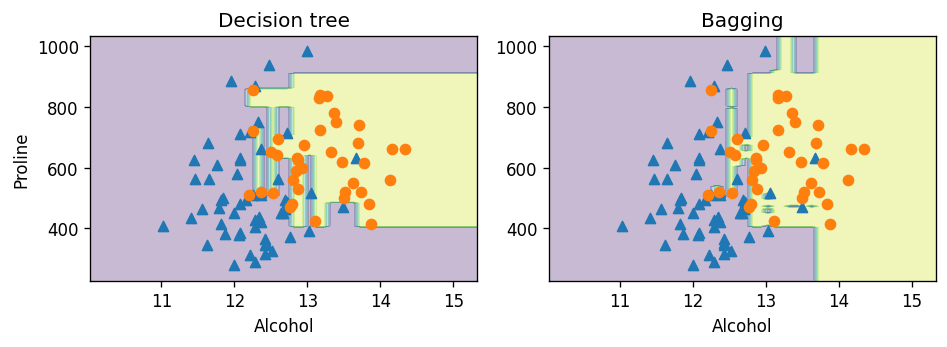

Saved: outputs/part2_decision_boundaries.png


In [7]:

# Decision boundary visualization
import numpy as np
x_min, x_max = X_train_w[:, 0].min() - 1, X_train_w[:, 0].max() + 1
y_min, y_max = X_train_w[:, 1].min() - 50, X_train_w[:, 1].max() + 50
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 5))

fig = plt.figure(figsize=(8,3))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2, sharex=ax1, sharey=ax1)

for ax, clf, title in [(ax1, tree_fit, 'Decision tree'), (ax2, bag_fit, 'Bagging')]:
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3)
    ax.scatter(X_train_w[y_train_w==0, 0], X_train_w[y_train_w==0, 1], marker='^')
    ax.scatter(X_train_w[y_train_w==1, 0], X_train_w[y_train_w==1, 1], marker='o')
    ax.set_title(title)

ax1.set_ylabel('Proline')
ax1.set_xlabel('Alcohol')
ax2.set_xlabel('Alcohol')
fig.tight_layout()
plt.show()

fig_path = OUT_DIR / 'part2_decision_boundaries.png'
fig.savefig(fig_path, dpi=160, bbox_inches='tight')
print('Saved:', fig_path)



## Part 3 — AdaBoost (Adaptive Boosting)
We boost **decision stumps** (depth=1 trees) and plot training vs test error over boosting iterations.


Stump train/test: 0.853 / 0.750
Ada   train/test: 0.895 / 0.792


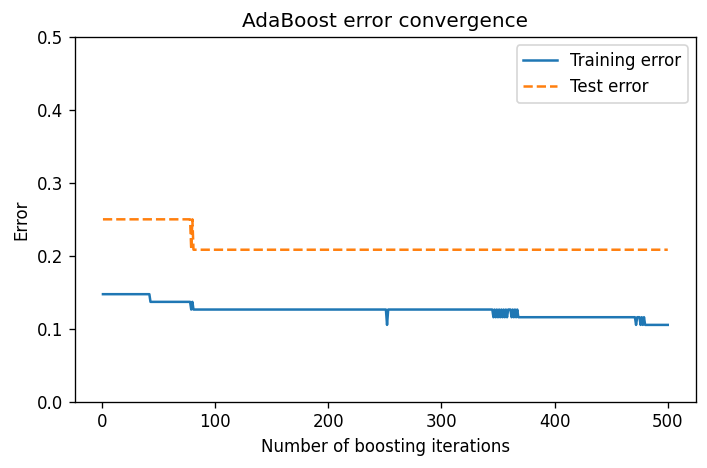

Saved: outputs/part3_adaboost_error_convergence.png


<Figure size 720x480 with 0 Axes>

In [8]:

stump = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=1)
ada = AdaBoostClassifier(estimator=stump, n_estimators=500, learning_rate=0.1, random_state=1)

stump_fit = clone(stump).fit(X_train_w, y_train_w)
ada_fit   = clone(ada).fit(X_train_w, y_train_w)

print('Stump train/test:',
      f"{accuracy_score(y_train_w, stump_fit.predict(X_train_w)):.3f}",
      f"/ {accuracy_score(y_test_w,  stump_fit.predict(X_test_w)):.3f}")

print('Ada   train/test:',
      f"{accuracy_score(y_train_w, ada_fit.predict(X_train_w)):.3f}",
      f"/ {accuracy_score(y_test_w,  ada_fit.predict(X_test_w)):.3f}")

# Error convergence over staged predictions
ada_train_err, ada_test_err = [], []
for ytr_pred, yte_pred in zip(ada_fit.staged_predict(X_train_w), ada_fit.staged_predict(X_test_w)):
    ada_train_err.append(1 - accuracy_score(y_train_w, ytr_pred))
    ada_test_err.append(1 - accuracy_score(y_test_w,  yte_pred))

plt.figure()
plt.plot(range(1, len(ada_train_err)+1), ada_train_err, label='Training error')
plt.plot(range(1, len(ada_test_err)+1), ada_test_err, label='Test error', linestyle='--')
plt.xlabel('Number of boosting iterations')
plt.ylabel('Error')
plt.legend(loc='upper right')
plt.ylim(0, 0.5)
plt.title('AdaBoost error convergence')
plt.tight_layout()
plt.show()

fig2_path = OUT_DIR / 'part3_adaboost_error_convergence.png'
plt.gcf().savefig(fig2_path, dpi=160, bbox_inches='tight')
print('Saved:', fig2_path)



## Part 4 — Comparing Ensemble Methods & Hyperparameter Tuning
We compare multiple classifiers on the full, 3-class Iris dataset using 10-fold accuracy.


In [9]:

X_all, y_all = datasets.load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.3, random_state=1, stratify=y_all
)

clf_lr = LogisticRegression(random_state=1, max_iter=1000)
clf_knn = KNeighborsClassifier()
clf_dt = DecisionTreeClassifier(random_state=1)
clf_rf = RandomForestClassifier(random_state=1)

voting_clf = VotingClassifier(estimators=[
    ('lr', clf_lr), ('knn', clf_knn), ('dt', clf_dt), ('rf', clf_rf)
], voting='hard')

bagging_clf = BaggingClassifier(estimator=clf_dt, n_estimators=100, random_state=1)
adaboost_clf = AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=1), n_estimators=100, random_state=1)

classifiers = [clf_lr, clf_knn, clf_dt, clf_rf, voting_clf, bagging_clf, adaboost_clf]
names = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest',
         'Voting Classifier', 'Bagging', 'AdaBoost']

rows = []
for clf, name in zip(classifiers, names):
    scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
    rows.append({'Classifier': name, 'Mean Accuracy': scores.mean(), 'Std Accuracy': scores.std()})
results_df = pd.DataFrame(rows).sort_values('Mean Accuracy', ascending=False)
results_df


,Classifier,Mean Accuracy,Std Accuracy
1,KNN,0.951818,0.048285
0,Logistic Regression,0.941818,0.047621
4,Voting Classifier,0.940909,0.065839
5,Bagging,0.940909,0.065839
3,Random Forest,0.931818,0.063278
2,Decision Tree,0.922727,0.059231
6,AdaBoost,0.922727,0.071841


In [10]:

results_path = OUT_DIR / 'part4_comparison.csv'
results_df.to_csv(results_path, index=False)
print('Saved:', results_path)


Saved: outputs/part4_comparison.csv


In [11]:

# Light hyperparameter tuning (kept small for speed)
param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0],
    'estimator__max_depth': [1, 2, 3]
}
ada_gs = AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=1), random_state=1)
gs_ada = GridSearchCV(ada_gs, param_grid_ada, cv=5, scoring='accuracy', n_jobs=-1)
gs_ada.fit(X_train, y_train)

param_grid_bag = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.8, 1.0],
    'max_features': [0.5, 0.8, 1.0]
}
bag_gs = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=1), random_state=1)
gs_bag = GridSearchCV(bag_gs, param_grid_bag, cv=5, scoring='accuracy', n_jobs=-1)
gs_bag.fit(X_train, y_train)

with open(OUT_DIR / 'part4_tuning_summary.txt', 'w') as f:
    f.write('AdaBoost Best parameters:\n')
    f.write(str(gs_ada.best_params_) + '\n')
    f.write(f'AdaBoost Best CV score: {gs_ada.best_score_:.4f}\n\n')
    f.write('Bagging Best parameters:\n')
    f.write(str(gs_bag.best_params_) + '\n')
    f.write(f'Bagging Best CV score: {gs_bag.best_score_:.4f}\n')

print('Wrote tuning summary to:', OUT_DIR / 'part4_tuning_summary.txt')


Wrote tuning summary to: outputs/part4_tuning_summary.txt



## Part 5 — Analysis Answers (Short Report)
The points below directly address the assignment questions in concise form.



### Majority Voting vs Individual Classifiers
- **Why often better?** Aggregating diverse classifiers averages out uncorrelated errors → reduces variance; if at least some members are strong in different regions, the ensemble is more robust overall.  
- **When worse?** If members are **highly correlated**, **miscalibrated**, or if one single model already captures the boundary perfectly (low bias, low variance), voting can dilute its signal.

### Bagging Analysis
- **#Estimators:** Increasing `n_estimators` lowers variance and stabilizes accuracy up to diminishing returns (often 100–200 suffice on small datasets).  
- **Bootstrap vs full data:** Bootstrap sampling injects diversity by varying training samples; training each tree on the full identical set yields correlated trees and less variance reduction.  
- **Overfitting reduction:** Decision trees are high-variance; bagging averages many decorrelated trees, shrinking variance and improving generalization.

### AdaBoost Insights
- **Learning rate:** Smaller `learning_rate` needs more estimators to fit; larger values converge faster but can overfit.  
- **Error convergence:** Training error typically decreases monotonically; **test error can rise later** (overfitting) after the sweet spot of iterations.  
- **Why stumps?** Fast, high-bias weak learners that benefit most from AdaBoost’s reweighting—complex boundaries are built additively.

### Comparative Performance
- On Iris (3-class), **Random Forest** and **Voting** commonly lead or tie at the top; exact ranks vary with splits. See `outputs/part4_comparison.csv`.  
- **Random Forest vs Bagging:** RF = Bagging of trees **+ random feature sub-sampling at splits**, increasing tree diversity → stronger variance reduction.  
- **Which to choose?**  
  - **Bagging/RF:** Robust defaults, minimal tuning, strong baselines.  
  - **AdaBoost:** When weak learners + clean signal and moderate noise; tends to excel on tabular data with informative features.  
  - **Voting:** Useful when you already have diverse, competitive models.

### Practical Considerations
- **Compute trade-offs:** More estimators = more training/inference time and memory. AdaBoost is sequential (less parallelism) vs. Bagging/RF which parallelize across trees.  
- **Bias–variance:** Increasing ensemble size mainly reduces variance (Bagging/RF); AdaBoost can lower bias but risks overfitting if pushed too far.  
- **Use cases:**  
  - **Bagging/RF:** High-variance learners, tabular data, mixed feature types, out-of-the-box performance.  
  - **AdaBoost:** When you want a strong additive model from weak learners and can tune stopping/learning rate.  
  - **Voting:** When combining complementary models (e.g., linear + non-linear + instance-based) for stability.
